Schritt 1 – Daten betrachten und Merkmale erkennen

In [63]:
import numpy as numpy
import requests
import pandas as pd
import matplotlib.pyplot as pyplot
from mpl_toolkits.mplot3d import axes3d
import json
from urllib.request import urlopen

In [64]:
def readDataSet(filename):
 
    fr = open(filename)                 # Datei-Stream vorbereiten
 
    numberOfLines = len(fr.readlines()) # Anzahl der Zeilen ermitteln
 
    returnMat = numpy.zeros((numberOfLines-1,3)) # Eine Numpy-Matrix in Höhe der Zeilenanzahl (minus Kopfzeile) und in Breite der drei Merkmal-Spalten
 
    classLabelVector = [] # Hier werden die tatsächlichen Kategorien (Haus, Wohnung, Büro) vermerkt
    classColorVector = [] # Hier werden die Kategorien über Farben vermerkt (zur späteren Unterscheidung im 3D-Plot!)
    
    #print(returnMat)   # Ggf. mal die noch die ausge-null-te Matrix anzeigen lassen (bei Python 2.7: die Klammern weglassen!)
    
    fr = open(filename) # Datei-Stream öffnen
    index = 0
    
    for line in fr.readlines():  # Zeile für Zeile der Datei lesen
        if index != 0:           # Kopfzeile überspringen
            line = line.strip()
            listFromLine = line.split('\t') # Jede Zeile wird zur temporären Liste (Tabulator als Trennzeichen)
 
            returnMat[index-1,:] = listFromLine[1:4] #Liste in die entsprechende Zeile der Matrix überführen
            
            classLabel = listFromLine[4]  # Kategorie (Haus, Wohnung, Büro) für diese Zeile merken
            
            if classLabel == "Buero":
                color = 'yellow'
            elif classLabel == "Wohnung":
                color = 'red'
            else:
                color = 'blue'
                        
            classLabelVector.append(classLabel) # Kategorie (Haus, Wohnung, Büro) als Text-Label speichern
            classColorVector.append(color)      # Kategorie als Farbe speichern (Büro = gelb, Wohnung = rot, Haus = Blau)
        
        index += 1
 
    return returnMat,classLabelVector, classColorVector

In [65]:
dataSet, classLabelVector, classColorVector = readDataSet('K_Nearest_Neigbour-DataSet.txt')

Schritt 2 – Merkmale im Verhältnis zueinander perspektivisch betrachten

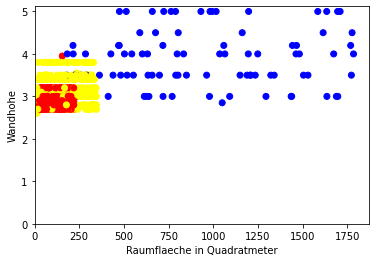

In [66]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.scatter(dataSet[:,0], dataSet[:,1], marker='o', color=classColorVector)
ax.set_xlabel("Raumflaeche in Quadratmeter")
ax.set_ylabel("Wandhohe")
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
pyplot.show()

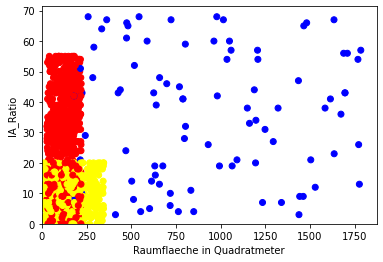

In [67]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.scatter(dataSet[:,0], dataSet[:,2], marker='o', color=classColorVector)
ax.set_xlabel("Raumflaeche in Quadratmeter")
ax.set_ylabel("IA_Ratio")
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
pyplot.show()

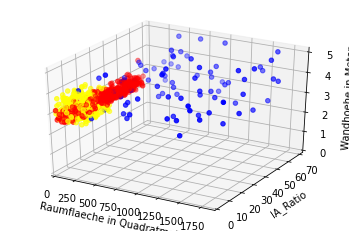

In [68]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataSet[:,0], dataSet[:,2], dataSet[:,1], marker='o', color=classColorVector)
ax.set_xlabel("Raumflaeche in Quadratmeter")
ax.set_ylabel("IA_Ratio")
ax.set_zlabel("Wandhoehe in Meter")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_zlim(bottom=0)
pyplot.show()

### Kalkulation der Distanzen zwischen den einzelnen Punkten

Bei der Berechnung der Distanz in einem Raum hilft uns der Satz des Pythagoras weiter. Die zu überbrückende Distanz, um von A nach B zu gelangen, lässt sich einfach berechnen, wenn man entlang der Raumdimensionen Katheten aufspannt. c = $\sqrt{a^2 + b^2}$
Distanz = $\sqrt{(q_1-p_1)^2+(q_2-p_2)^2+…+(q_n-p_n)^2}$
Um mit den unterschiedlichen Werte besser in ihrer Relation zu sehen, sollten sie einer Normalisierung unterzogen werden. Dabei werden alle Werte einer Dimension einem Bereich zwischen 0.00 und 1.00 zugeordnet, wobei 0.00 stets das Minimum und 1.00 das Maximum darstellt.

NormWert = $\frac{Wert - Min}{Wertspanne} = \frac{Wert - Min}{Max - Min}$



In [69]:
def normalizeDataSet(dataSet):
    
    dataSet_n = numpy.zeros(numpy.shape(dataSet))     #[[ 0. 0. 0.]
                                                      # [ 0. 0. 0.]
                                                      # [ 0. 0. 0.]
                                                      # ..., 
                                                      # [ 0. 0. 0.]
                                                      # [ 0. 0. 0.]
                                                      # [ 0. 0. 0.]]
    
    minValues = dataSet.min(0)                        # [ 10. 2.6 0.]
    ranges = dataSet.max(0) - dataSet.min(0)          # [ 1775. 2.4 68.]
    
    minValues = dataSet.min(0)                        # [ 10. 2.6 0.]
    maxValues = dataSet.max(0)                        # [ 1785. 5. 68.]
 
    ranges = maxValues - minValues                    # [ 1775. 2.4 68.]
 
    rowCount = dataSet.shape[0]                       # 1039 
    
    # numpy.tile() wiederholt Sequenzen (hier:  [[ 10. 2.6 0. ], ..., [ 10. 2.6 0. ]]
 
    dataSet_n = dataSet - numpy.tile(minValues, (rowCount, 1))  #[[ 2.56000000e+02 9.00000000e-01 1.80000000e+01]
                                                                # [ 6.60000000e+01 2.00000000e-01 5.40000000e+01]
                                                                # [ 3.32000000e+02 1.50000000e-01 1.00000000e+01]
                                                                # ..., 
                                                                # [ 1.58000000e+02 6.00000000e-01 0.00000000e+00]
                                                                # [ 5.70000000e+01 1.00000000e-01 5.20000000e+01]
                                                                # [ 1.68000000e+02 2.00000000e-01 0.00000000e+00]]
 
    dataSet_n = dataSet_n / numpy.tile(ranges, (rowCount, 1))   #[[ 0.14422535 0.375 0.26470588]
                                                                # [ 0.0371831 0.08333333 0.79411765]
                                                                # [ 0.18704225 0.0625 0.14705882]
                                                                # ..., 
                                                                # [ 0.08901408 0.25 0.]
                                                                # [ 0.03211268 0.04166667 0.76470588]
                                                                # [ 0.09464789 0.08333333 0.]]
 
    #print(dataSet_n)
        
    return dataSet_n, ranges, minValues
 

In [70]:
dataSet_n, ranges, minValues = normalizeDataSet(dataSet)

In [71]:
def classify(inX, dataSet, labels, k):
    rowCount = dataSet.shape[0]              # Anzahl an Zeilen bestimmen
    diffMat = numpy.tile(inX, (rowCount,1)) - dataSet # Berechnung der Katheten 
    # (über tile() wird der Eingangsdatensatz über die Zeilenanzahl des dataSet vervielfacht, der dataSet davon substrahiert)
    sqDiffMat = diffMat**2                   # Quadrat der Katheten
    sqDistances = sqDiffMat.sum(axis=1)      # Aufsummieren der Differenzpaare
    distances = sqDistances**0.5             # Quadratwurzel über alle Werte
    sortedDistIndicies = distances.argsort() # Aufsteigende Sortierung  
    classCount = {} 
    #print("inX = %s, k = %s" % (inX, k))
    #print(sortedDistIndicies)  
    for i in range(k):                                        # Eingrenzung auf k-Werte in der sortierten Liste 
        closest = labels[sortedDistIndicies[i]]    # Label (Kategorie [Büro, Wohnung, Haus] entsprechend der Sortierung aufnehmen
        classCount[closest] = classCount.get(closest, 0) + 1  # Aufbau eines Dictionary über die 
        sortedClassCount = sorted(classCount, key = classCount.get, reverse=True) 
    # Absteigende Sortierung der gesammelten Labels in k-Reichweite
    # wobei die Sortierung über den Count (Value) erfolgt
    #print(classCount)       
    #print(sortedClassCount[0])
    return sortedClassCount[0]   # Liefere das erste Label zurück also das Label mit der höchsten Anzahl innerhalb 
    # der k-Reichweite

In [72]:
errorCount = 0
    
k = 5                             # k-Eingrenzung (hier: auf 5 Nachbarn einschränken)
 
rowCount = dataSet_n.shape[0]     # Anzahl der Zeilen im gesamten Datensatz
 
numTestVectors = 30               # Datensätze 0 - 29 werden zum testen von k verwendet,
                                   # die Datensätze ab Zeile 30 werden zur Klassifikation verwendet
for i in range(0, numTestVectors): # Aufruf des Klassifikators von 0 bis 29 
    result = classify(dataSet_n[i,:], dataSet_n[numTestVectors:rowCount,:], classLabelVector[numTestVectors:rowCount], k)
    print("%s - the classifier came back with: %s, the real answer is: %s" %(i, result, classLabelVector[i]))

    if (result != classLabelVector[i]):
        errorCount += 1.0
print("Error Count: %d" % errorCount)

0 - the classifier came back with: Buero, the real answer is: Buero
1 - the classifier came back with: Wohnung, the real answer is: Wohnung
2 - the classifier came back with: Buero, the real answer is: Buero
3 - the classifier came back with: Wohnung, the real answer is: Buero
4 - the classifier came back with: Wohnung, the real answer is: Wohnung
5 - the classifier came back with: Buero, the real answer is: Wohnung
6 - the classifier came back with: Wohnung, the real answer is: Wohnung
7 - the classifier came back with: Wohnung, the real answer is: Buero
8 - the classifier came back with: Wohnung, the real answer is: Wohnung
9 - the classifier came back with: Wohnung, the real answer is: Wohnung
10 - the classifier came back with: Wohnung, the real answer is: Wohnung
11 - the classifier came back with: Wohnung, the real answer is: Wohnung
12 - the classifier came back with: Buero, the real answer is: Buero
13 - the classifier came back with: Wohnung, the real answer is: Buero
14 - the